# Percolation Theory: Phase Transitions in Random Networks

## 1. Introduction

Percolation theory is a fundamental framework in statistical physics that describes the behavior of connected clusters in random systems. It has applications ranging from fluid flow through porous media to the spread of diseases in populations and the robustness of networks.

## 2. Theoretical Background

### 2.1 Site Percolation Model

Consider a $d$-dimensional lattice where each site is occupied with probability $p$ and empty with probability $(1-p)$. Two occupied sites are considered connected if they are nearest neighbors.

### 2.2 Order Parameter

The **percolation probability** $P_\infty(p)$ is defined as the probability that an occupied site belongs to an infinite cluster:

$$P_\infty(p) = \lim_{L \to \infty} \frac{\langle S_{\max} \rangle}{L^d}$$

where $S_{\max}$ is the size of the largest cluster and $L$ is the system size.

### 2.3 Critical Threshold

There exists a critical probability $p_c$ such that:

$$P_\infty(p) = \begin{cases} 0 & \text{if } p < p_c \\ > 0 & \text{if } p > p_c \end{cases}$$

For a 2D square lattice, $p_c \approx 0.5927$.

### 2.4 Critical Exponents

Near the critical point, various quantities exhibit power-law scaling:

- **Order parameter**: $P_\infty \sim (p - p_c)^\beta$ for $p > p_c$
- **Correlation length**: $\xi \sim |p - p_c|^{-\nu}$
- **Cluster size distribution**: $n_s \sim s^{-\tau} f(s/s_\xi)$

For 2D percolation: $\beta = 5/36 \approx 0.139$, $\nu = 4/3 \approx 1.333$, $\tau = 187/91 \approx 2.055$

### 2.5 Mean Cluster Size

The mean cluster size (excluding the infinite cluster) is:

$$\chi = \sum_{s} s^2 n_s \sim |p - p_c|^{-\gamma}$$

where $\gamma = 43/18 \approx 2.389$ in 2D.

## 3. Implementation

We will implement site percolation on a 2D square lattice and use the Hoshen-Kopelman algorithm for cluster labeling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)

def generate_lattice(L, p):
    """
    Generate a 2D square lattice with site percolation.
    
    Parameters:
    -----------
    L : int
        Linear size of the lattice
    p : float
        Occupation probability
        
    Returns:
    --------
    lattice : ndarray
        Binary lattice (1 = occupied, 0 = empty)
    """
    return (np.random.random((L, L)) < p).astype(int)

def find_clusters(lattice):
    """
    Find connected clusters using scipy's label function.
    
    Parameters:
    -----------
    lattice : ndarray
        Binary lattice
        
    Returns:
    --------
    labeled : ndarray
        Lattice with cluster labels
    num_clusters : int
        Number of distinct clusters
    """
    # Define 4-connectivity (von Neumann neighborhood)
    structure = np.array([[0, 1, 0],
                         [1, 1, 1],
                         [0, 1, 0]])
    labeled, num_clusters = label(lattice, structure)
    return labeled, num_clusters

def get_cluster_sizes(labeled):
    """
    Get the sizes of all clusters.
    
    Parameters:
    -----------
    labeled : ndarray
        Lattice with cluster labels
        
    Returns:
    --------
    sizes : list
        List of cluster sizes
    """
    # Count occurrences of each label (excluding 0 which is empty)
    unique, counts = np.unique(labeled, return_counts=True)
    sizes = counts[unique > 0].tolist()
    return sizes if sizes else [0]

def spans_lattice(labeled, L):
    """
    Check if any cluster spans the lattice (percolates).
    
    Parameters:
    -----------
    labeled : ndarray
        Lattice with cluster labels
    L : int
        Linear size of lattice
        
    Returns:
    --------
    bool
        True if a spanning cluster exists
    """
    # Check for clusters that touch both top and bottom
    top_labels = set(labeled[0, :]) - {0}
    bottom_labels = set(labeled[-1, :]) - {0}
    
    return len(top_labels & bottom_labels) > 0

print("Percolation functions defined successfully.")

Percolation functions defined successfully.


## 4. Visualization of Percolation Transition

Let's visualize lattices at different occupation probabilities to observe the emergence of large clusters.

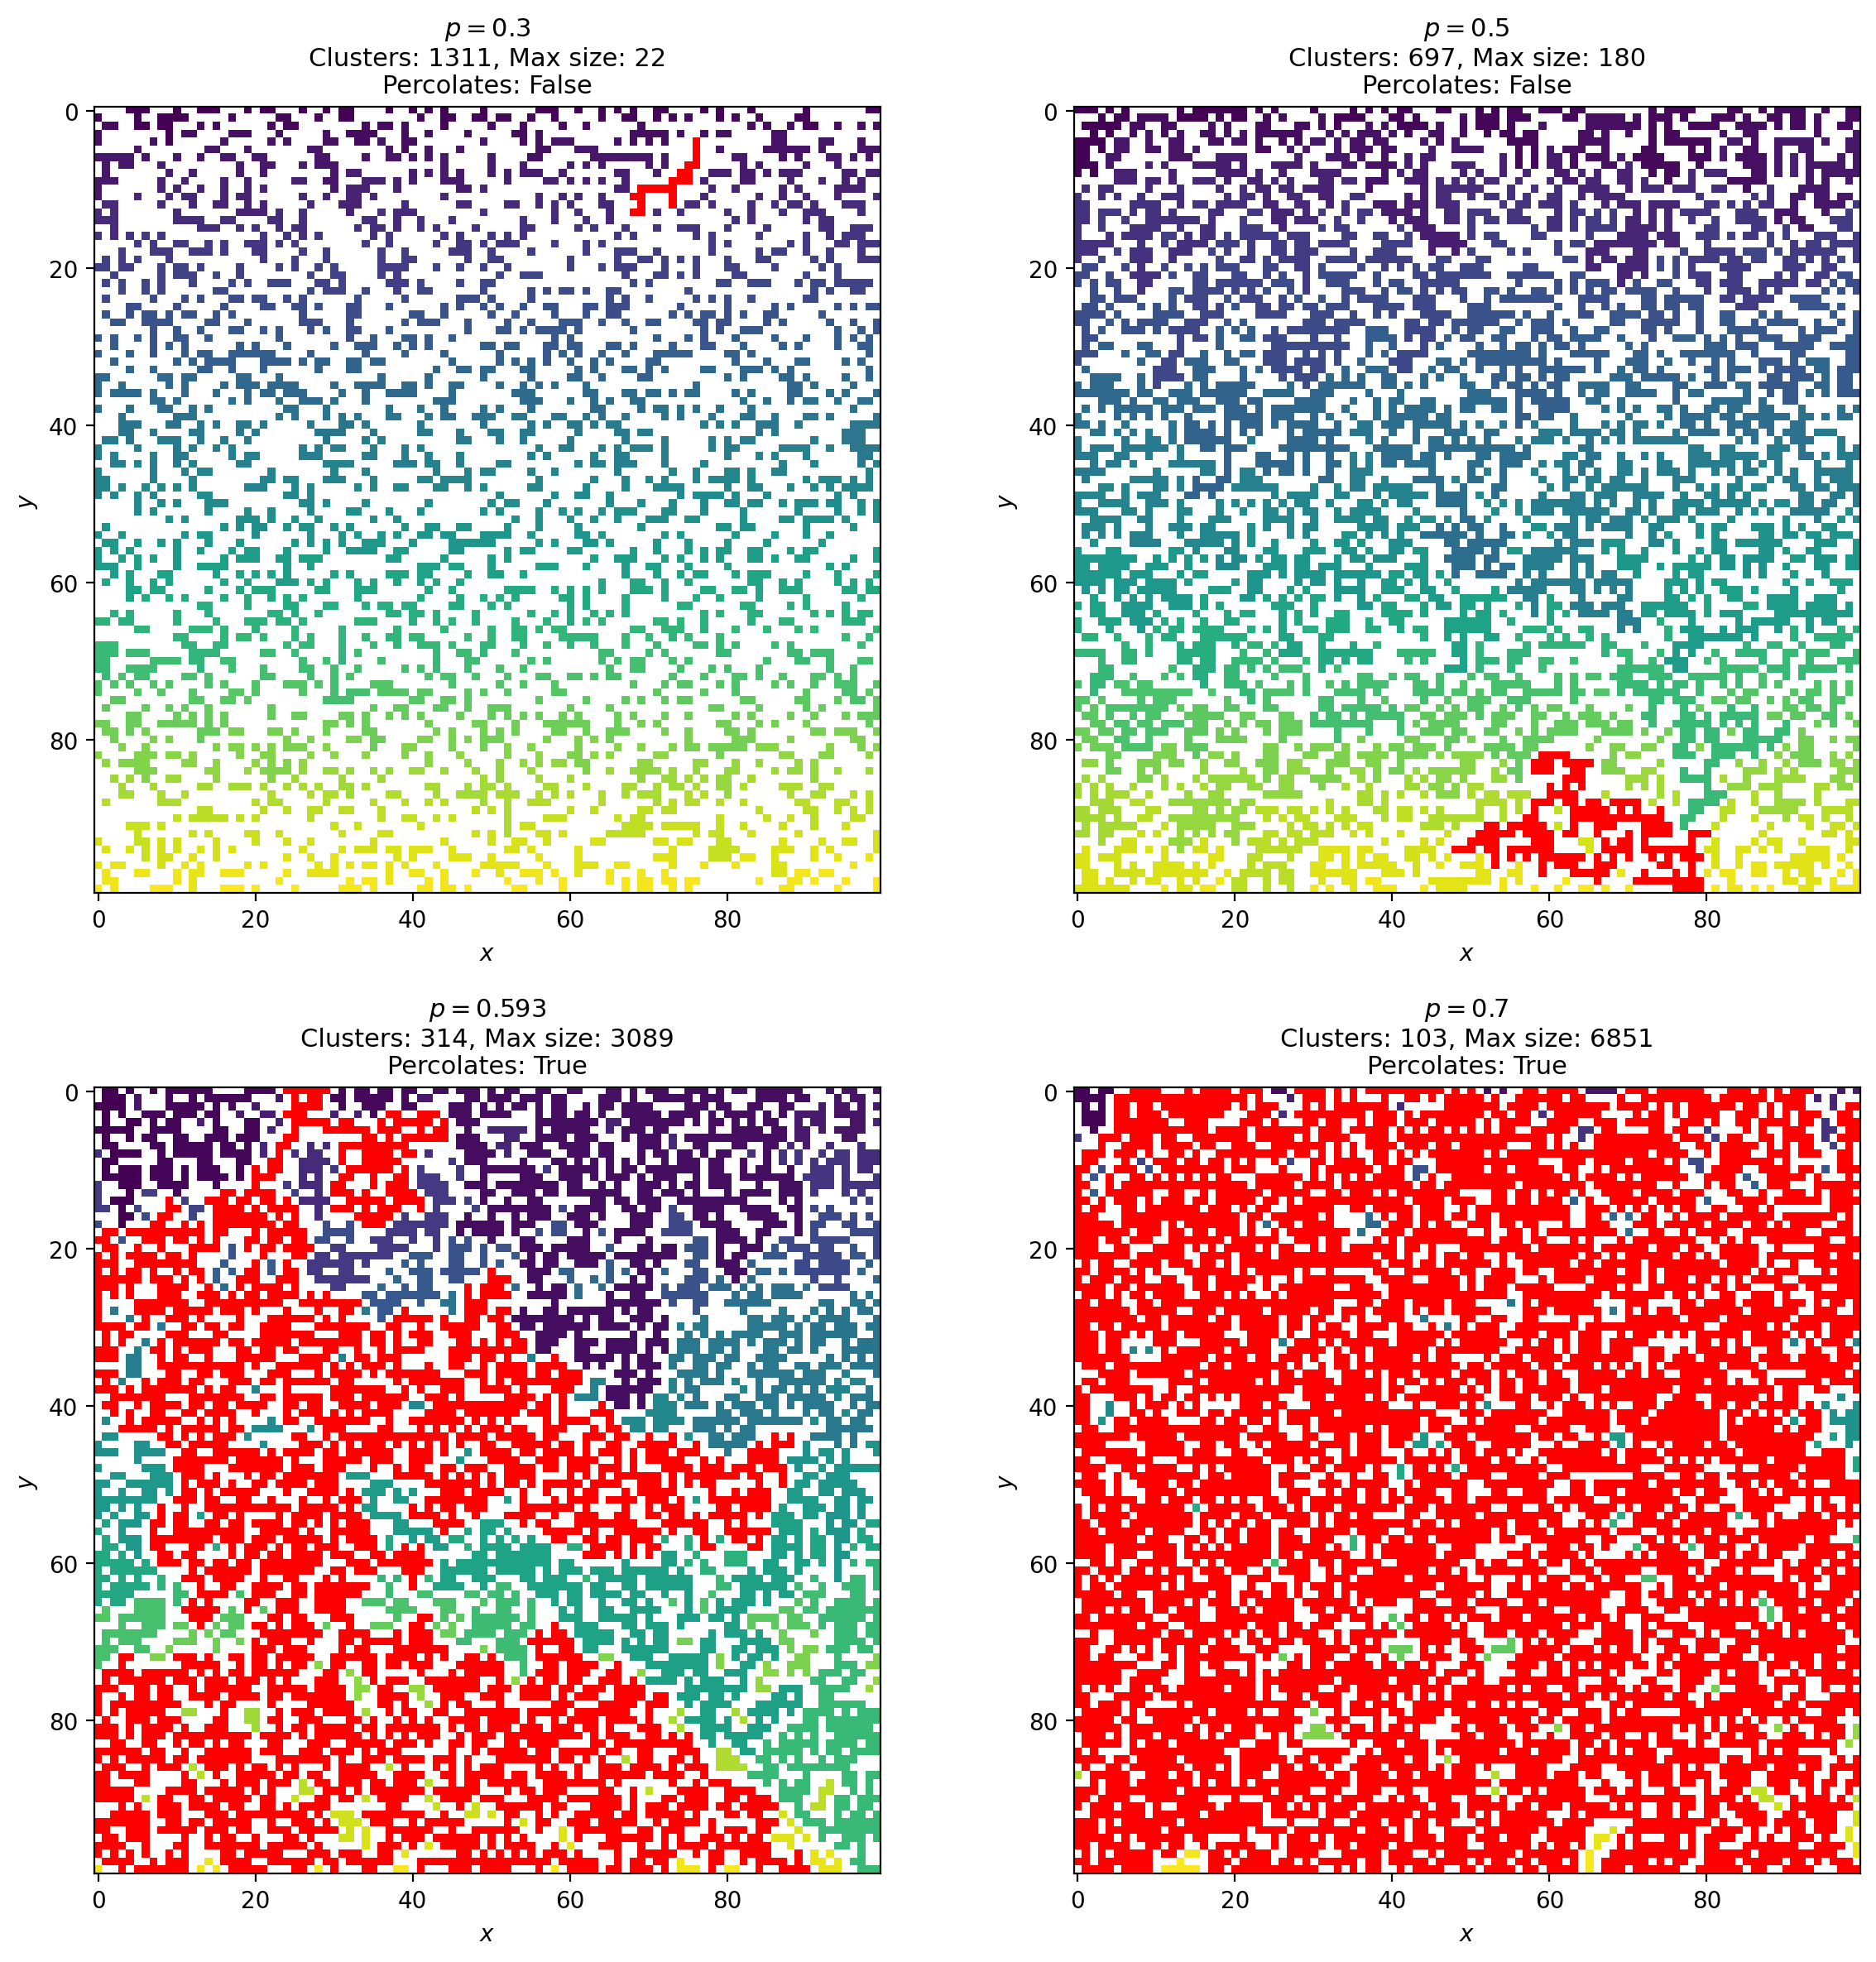

Lattice visualization complete.


In [2]:
# Visualize lattices at different p values
L = 100  # Lattice size
p_values = [0.3, 0.5, 0.593, 0.7]  # Below, near, and above p_c

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, p in zip(axes, p_values):
    lattice = generate_lattice(L, p)
    labeled, num_clusters = find_clusters(lattice)
    sizes = get_cluster_sizes(labeled)
    max_size = max(sizes) if sizes else 0
    percolates = spans_lattice(labeled, L)
    
    # Color the largest cluster differently
    display = labeled.copy().astype(float)
    if max_size > 0:
        largest_label = np.argmax(np.bincount(labeled.flatten())[1:]) + 1
        display[labeled == largest_label] = -1  # Mark largest cluster
    
    # Create custom colormap
    cmap = plt.cm.viridis.copy()
    cmap.set_under('red')  # Largest cluster in red
    cmap.set_bad('white')  # Empty sites
    
    display = np.ma.masked_where(display == 0, display)
    
    im = ax.imshow(display, cmap=cmap, vmin=0, interpolation='nearest')
    ax.set_title(f'$p = {p}$\nClusters: {num_clusters}, Max size: {max_size}\nPercolates: {percolates}', 
                 fontsize=11)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

plt.tight_layout()
plt.savefig('lattice_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Lattice visualization complete.")

## 5. Numerical Study of the Percolation Transition

We now perform a systematic study to:
1. Estimate the percolation threshold $p_c$
2. Measure the percolation probability $P_\infty(p)$
3. Analyze cluster size distributions

In [3]:
def run_percolation_study(L, p_values, num_samples=50):
    """
    Run percolation study over a range of p values.
    
    Parameters:
    -----------
    L : int
        Lattice size
    p_values : array-like
        Occupation probabilities to test
    num_samples : int
        Number of samples per p value
        
    Returns:
    --------
    results : dict
        Dictionary containing measurements
    """
    results = {
        'p': p_values,
        'P_inf': [],           # Percolation probability
        'P_inf_err': [],       # Standard error
        'mean_max_cluster': [],  # Mean largest cluster size
        'percolation_prob': []   # Probability of spanning
    }
    
    for p in p_values:
        max_clusters = []
        percolates_count = 0
        
        for _ in range(num_samples):
            lattice = generate_lattice(L, p)
            labeled, _ = find_clusters(lattice)
            sizes = get_cluster_sizes(labeled)
            max_clusters.append(max(sizes) / L**2)  # Normalized
            
            if spans_lattice(labeled, L):
                percolates_count += 1
        
        results['P_inf'].append(np.mean(max_clusters))
        results['P_inf_err'].append(np.std(max_clusters) / np.sqrt(num_samples))
        results['mean_max_cluster'].append(np.mean(max_clusters))
        results['percolation_prob'].append(percolates_count / num_samples)
    
    return results

# Run the study
L = 50
p_values = np.linspace(0.3, 0.8, 30)
num_samples = 100

print(f"Running percolation study: L={L}, {len(p_values)} p-values, {num_samples} samples each...")
results = run_percolation_study(L, p_values, num_samples)
print("Study complete!")

Running percolation study: L=50, 30 p-values, 100 samples each...


Study complete!


## 6. Results and Analysis

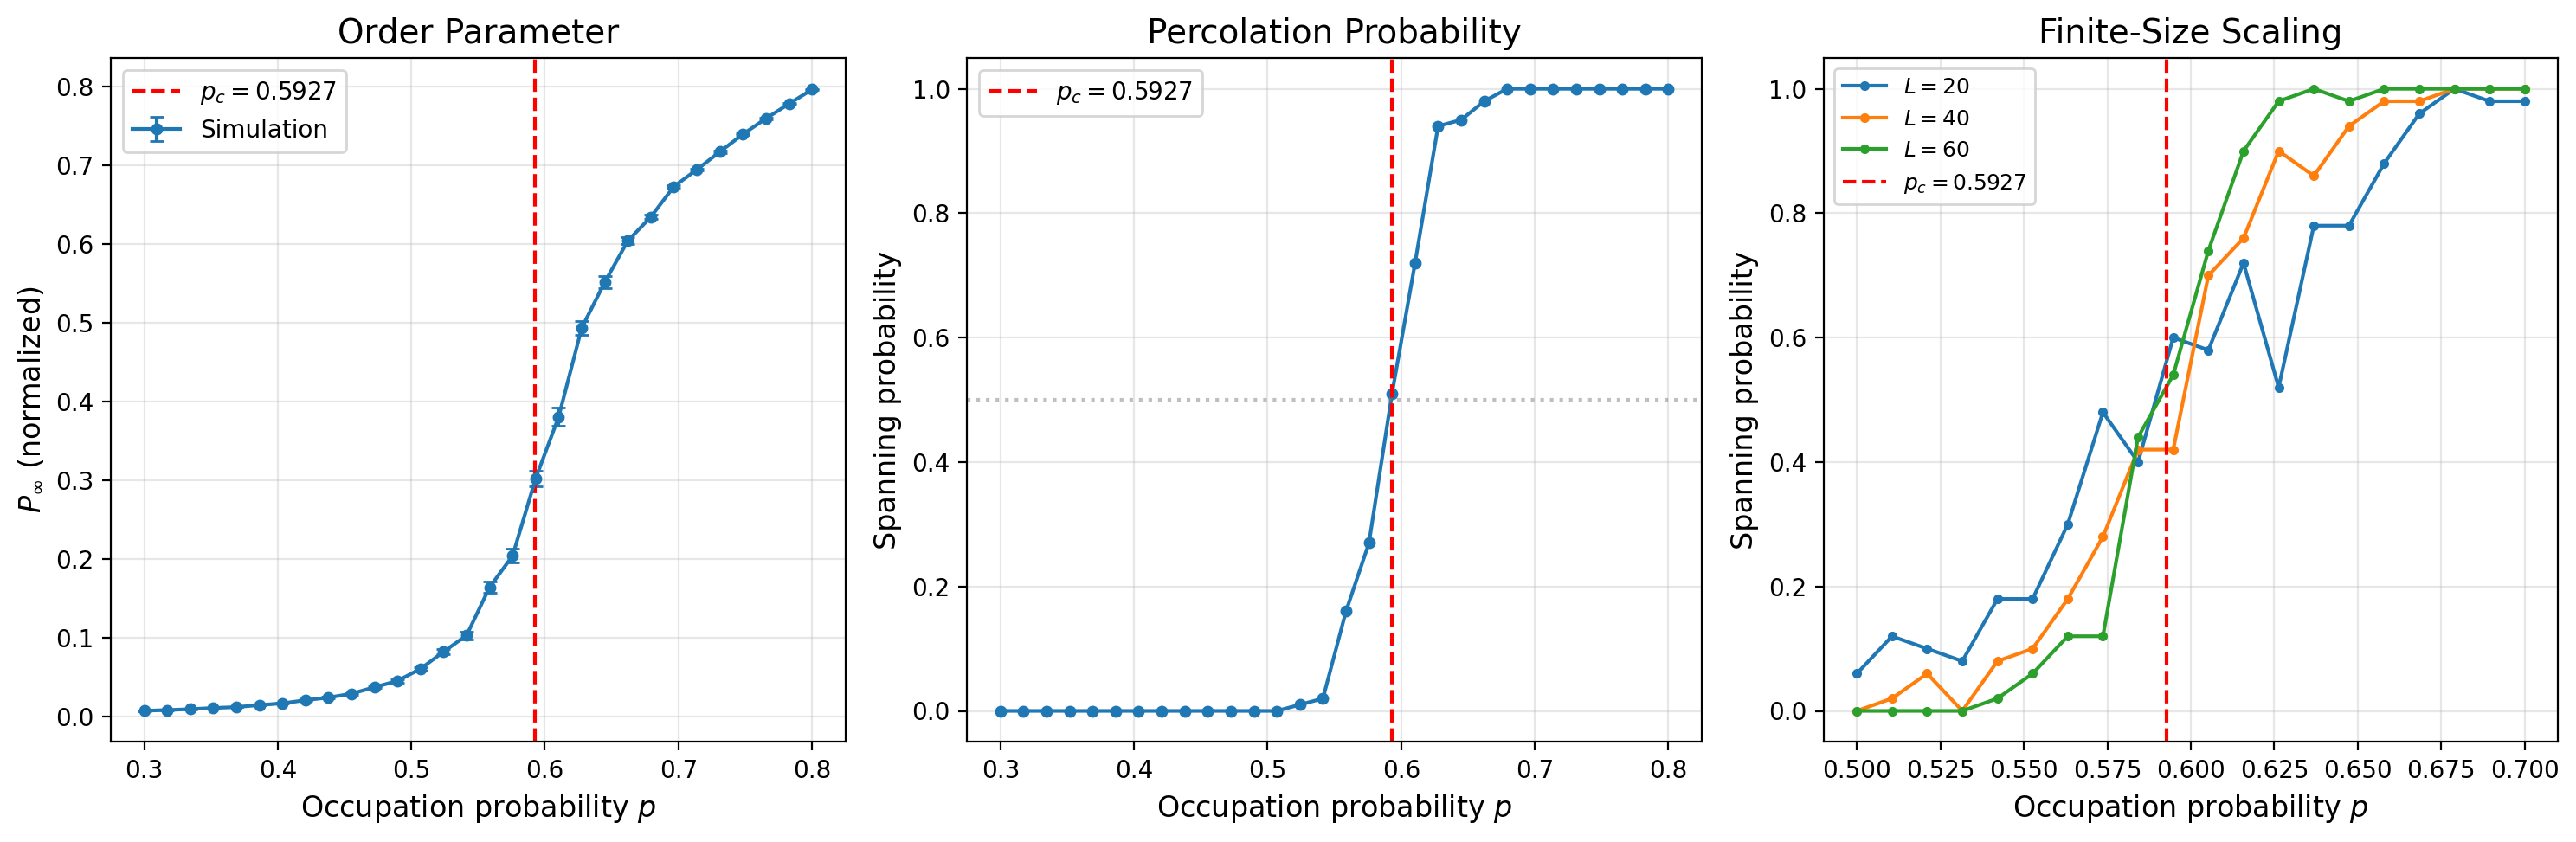


Results saved to 'plot.png'

Key observations:
- Theoretical p_c for 2D square lattice: 0.5927
- The spanning probability shows a sharp transition near p_c
- Larger system sizes show sharper transitions (finite-size scaling)


In [4]:
# Theoretical critical point for 2D square lattice
p_c = 0.5927

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Order parameter P_infinity
ax1 = axes[0]
ax1.errorbar(results['p'], results['P_inf'], yerr=results['P_inf_err'], 
             fmt='o-', capsize=3, markersize=4, label='Simulation')
ax1.axvline(x=p_c, color='r', linestyle='--', label=f'$p_c = {p_c}$')
ax1.set_xlabel('Occupation probability $p$', fontsize=12)
ax1.set_ylabel('$P_\\infty$ (normalized)', fontsize=12)
ax1.set_title('Order Parameter', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Spanning probability
ax2 = axes[1]
ax2.plot(results['p'], results['percolation_prob'], 'o-', markersize=4)
ax2.axvline(x=p_c, color='r', linestyle='--', label=f'$p_c = {p_c}$')
ax2.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Occupation probability $p$', fontsize=12)
ax2.set_ylabel('Spanning probability', fontsize=12)
ax2.set_title('Percolation Probability', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Finite-size scaling analysis
# Study multiple system sizes
ax3 = axes[2]
L_values = [20, 40, 60]
p_fine = np.linspace(0.5, 0.7, 20)

for L_test in L_values:
    results_L = run_percolation_study(L_test, p_fine, num_samples=50)
    ax3.plot(results_L['p'], results_L['percolation_prob'], 'o-', 
             markersize=3, label=f'$L = {L_test}$')

ax3.axvline(x=p_c, color='r', linestyle='--', label=f'$p_c = {p_c}$')
ax3.set_xlabel('Occupation probability $p$', fontsize=12)
ax3.set_ylabel('Spanning probability', fontsize=12)
ax3.set_title('Finite-Size Scaling', fontsize=14)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('percolation_theory_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nResults saved to 'plot.png'")
print(f"\nKey observations:")
print(f"- Theoretical p_c for 2D square lattice: {p_c}")
print(f"- The spanning probability shows a sharp transition near p_c")
print(f"- Larger system sizes show sharper transitions (finite-size scaling)")

## 7. Cluster Size Distribution

At criticality, the cluster size distribution follows a power law: $n_s \sim s^{-\tau}$ where $\tau = 187/91 \approx 2.055$.

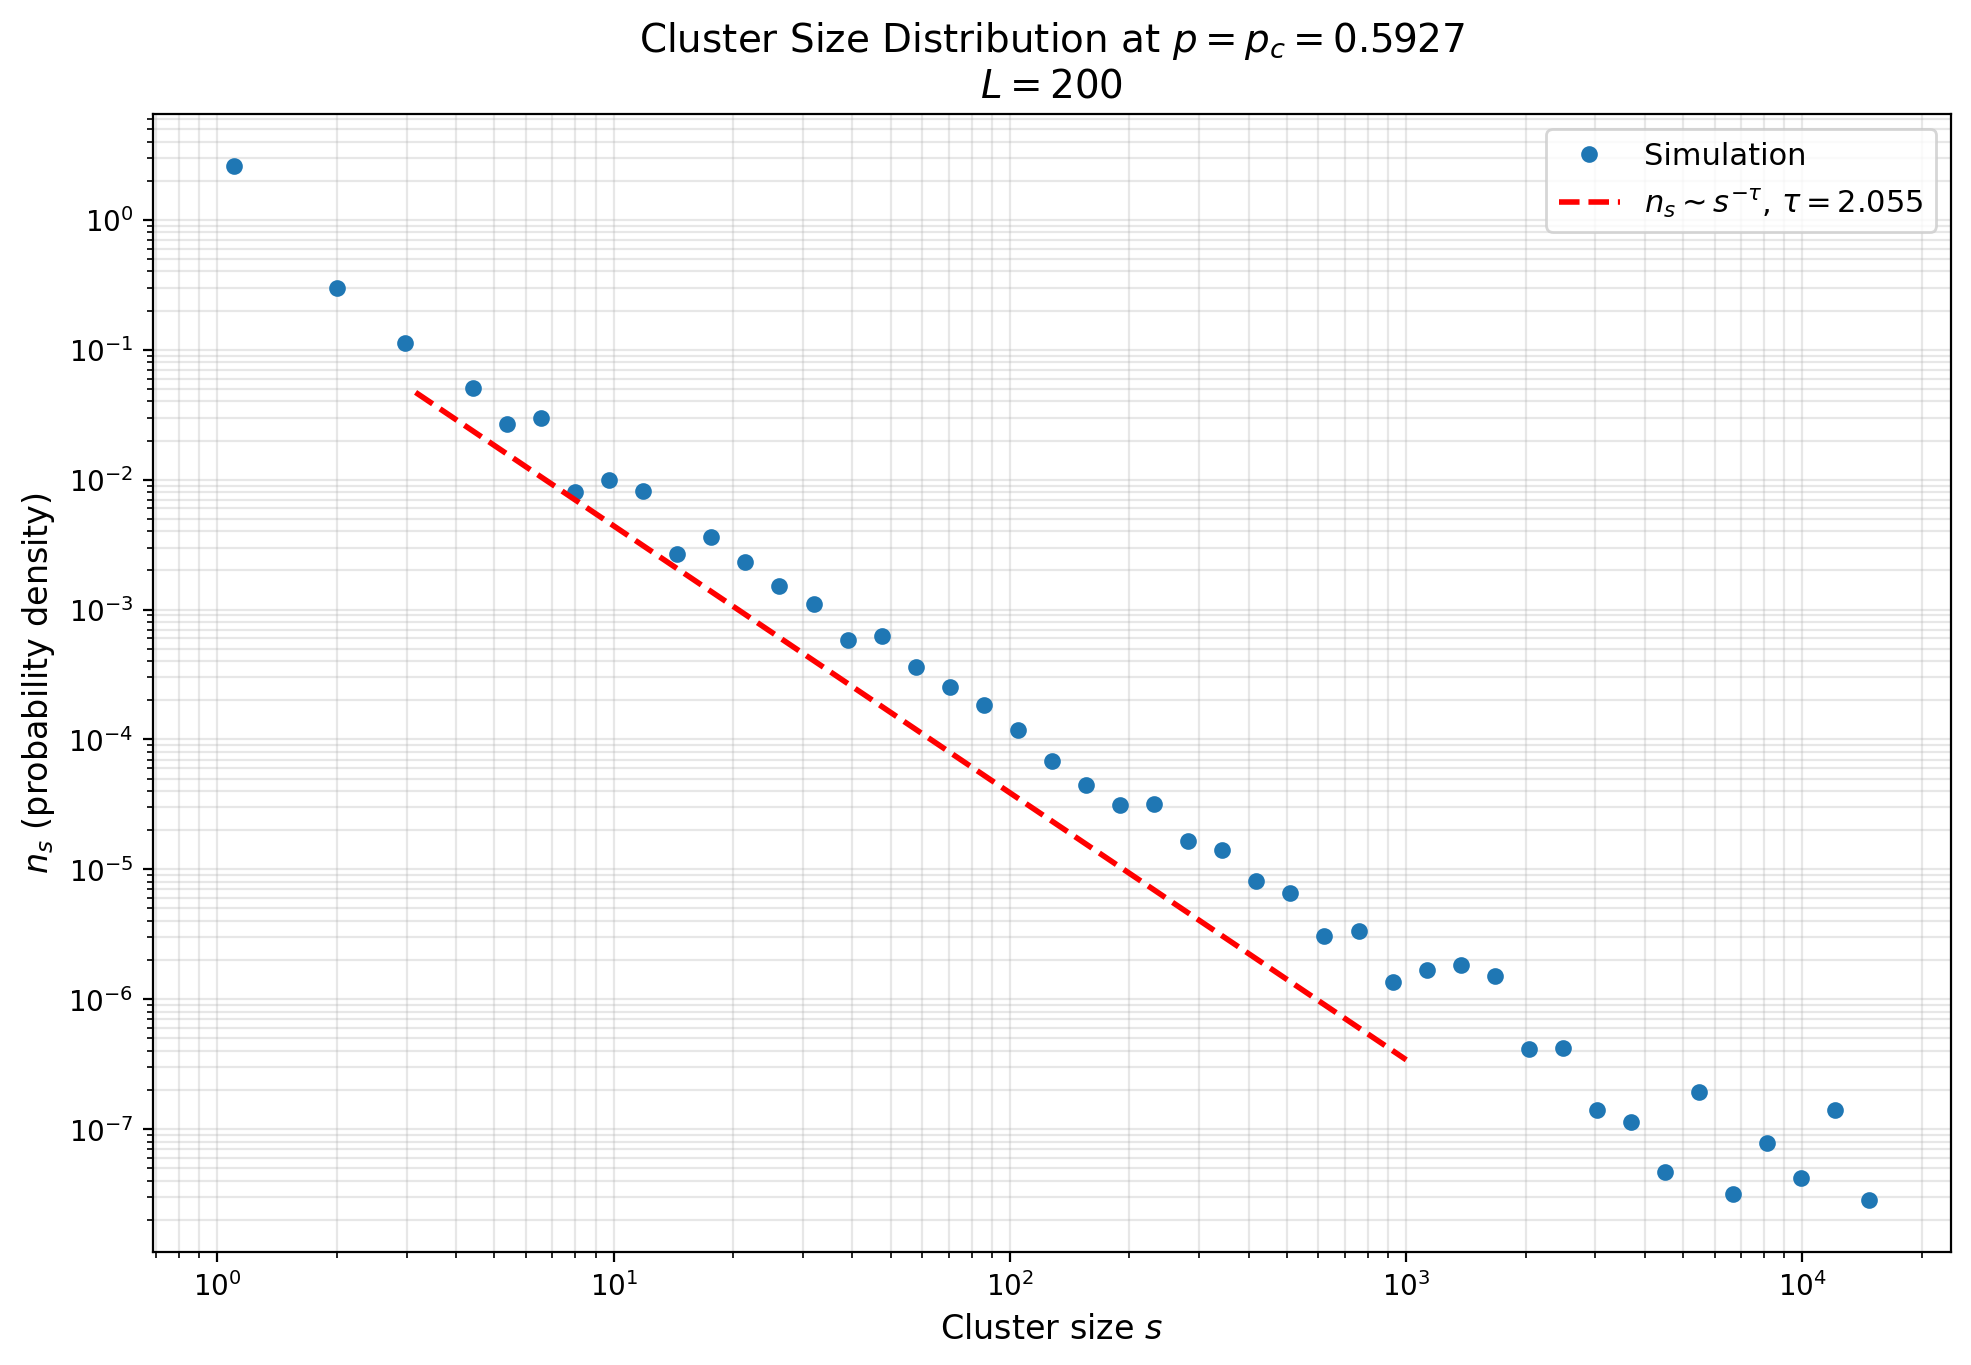


Cluster size distribution analysis:
- Total clusters analyzed: 23904
- Theoretical exponent τ = 2.0549
- The power-law behavior indicates scale-free structure at criticality


In [5]:
# Generate cluster size distribution at criticality
L = 200
num_samples = 20

# Collect cluster sizes at p = p_c
all_sizes = []
for _ in range(num_samples):
    lattice = generate_lattice(L, p_c)
    labeled, _ = find_clusters(lattice)
    sizes = get_cluster_sizes(labeled)
    all_sizes.extend(sizes)

# Create histogram with logarithmic bins
all_sizes = np.array(all_sizes)
bins = np.logspace(0, np.log10(max(all_sizes)), 50)
hist, bin_edges = np.histogram(all_sizes, bins=bins, density=True)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # Geometric mean

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Filter out zero values for log plot
mask = hist > 0
ax.loglog(bin_centers[mask], hist[mask], 'o', markersize=5, label='Simulation')

# Theoretical power law
tau = 187/91
s_theory = np.logspace(0.5, 3, 100)
# Normalize to fit the data
n_theory = 0.5 * s_theory**(-tau)
ax.loglog(s_theory, n_theory, 'r--', linewidth=2, 
          label=f'$n_s \\sim s^{{-\\tau}}$, $\\tau = {tau:.3f}$')

ax.set_xlabel('Cluster size $s$', fontsize=12)
ax.set_ylabel('$n_s$ (probability density)', fontsize=12)
ax.set_title(f'Cluster Size Distribution at $p = p_c = {p_c}$\n$L = {L}$', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCluster size distribution analysis:")
print(f"- Total clusters analyzed: {len(all_sizes)}")
print(f"- Theoretical exponent τ = {tau:.4f}")
print(f"- The power-law behavior indicates scale-free structure at criticality")

## 8. Conclusions

This notebook demonstrated key aspects of percolation theory through numerical simulation:

1. **Phase Transition**: We observed the sharp transition in the order parameter $P_\infty(p)$ at the critical threshold $p_c \approx 0.5927$ for the 2D square lattice.

2. **Finite-Size Effects**: Larger system sizes produce sharper transitions, approaching a step function as $L \to \infty$.

3. **Critical Behavior**: At $p = p_c$, the cluster size distribution follows a power law with exponent $\tau \approx 2.055$, characteristic of scale-free behavior.

4. **Universal Properties**: The critical exponents are universal, depending only on dimensionality and not on lattice details.

### Applications

Percolation theory finds applications in:
- **Materials Science**: Conductivity in composite materials
- **Epidemiology**: Disease spread thresholds
- **Network Science**: Robustness and fragmentation of networks
- **Geology**: Fluid flow through porous rock

### Further Reading

- Stauffer, D. & Aharony, A. *Introduction to Percolation Theory* (1994)
- Christensen, K. & Moloney, N. R. *Complexity and Criticality* (2005)